## Лабораторна робота №2
* Тема: Застосування методів кластеризації та зменшення розмірності.
* Мета: Ознайомитися з алгоритмами кластеризації K-Means та Fuzzy С-Means. Вивчити вплив зменшення розмірності даних за допомогою PCA на
результати кластеризації. Порівняти отримані кластери  а допомогою метри 
(наприклад, silhouette score). Розробити програмне рішення на Pythonз 
використанням бібліотек scikit-learn та scikit-fuzzy.
* Варіант №1
* Виконала студентка групи ОІ-21сп 
* Вишинська Наталіяталія

#### Імпорт бібліотек (в одному рядку)

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
import sklearn.datasets
import sklearn.preprocessing as sp
import sklearn.decomposition as sd
import sklearn.cluster as sc
import sklearn.mixture as sm
import sklearn.metrics as smetrics
import scipy.spatial.distance as ssd
import mpl_toolkits.mplot3d as m3d
import sklearn.neighbors as sn

os.environ["OMP_NUM_THREADS"] = "1"

#### 1. Підготовка даних
#### 1.1 Вибір набору даних

In [5]:
# Завантаження датасету Calories (варіант 1)
df = pd.read_csv("./calories.csv")
X = df.drop(columns=["Calories", "User_ID"])
print("Розмір даних:", X.shape)
X.head()

Розмір даних: (15000, 7)


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,68,190.0,94.0,29.0,105.0,40.8
1,female,20,166.0,60.0,14.0,94.0,40.3
2,male,69,179.0,79.0,5.0,88.0,38.7
3,female,34,179.0,71.0,13.0,100.0,40.5
4,female,27,154.0,58.0,10.0,81.0,39.8


#### 1.2 Попередня обробка даних

Пропущені значення:
 Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64
Оновлені дані після масштабування (для KMeans, FCM, GMM):


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,1,0.813559,1.089582,1.265909,0.965517,0.989404,0.840909
1,0,0.000000,-0.593726,-0.995458,0.448276,-0.158461,0.727273
2,1,0.830508,0.318066,0.268247,0.137931,-0.784569,0.363636
3,0,0.237288,0.318066,-0.263839,0.413793,0.467647,0.772727
4,0,0.118644,-1.435380,-1.128480,0.310345,-1.515029,0.613636


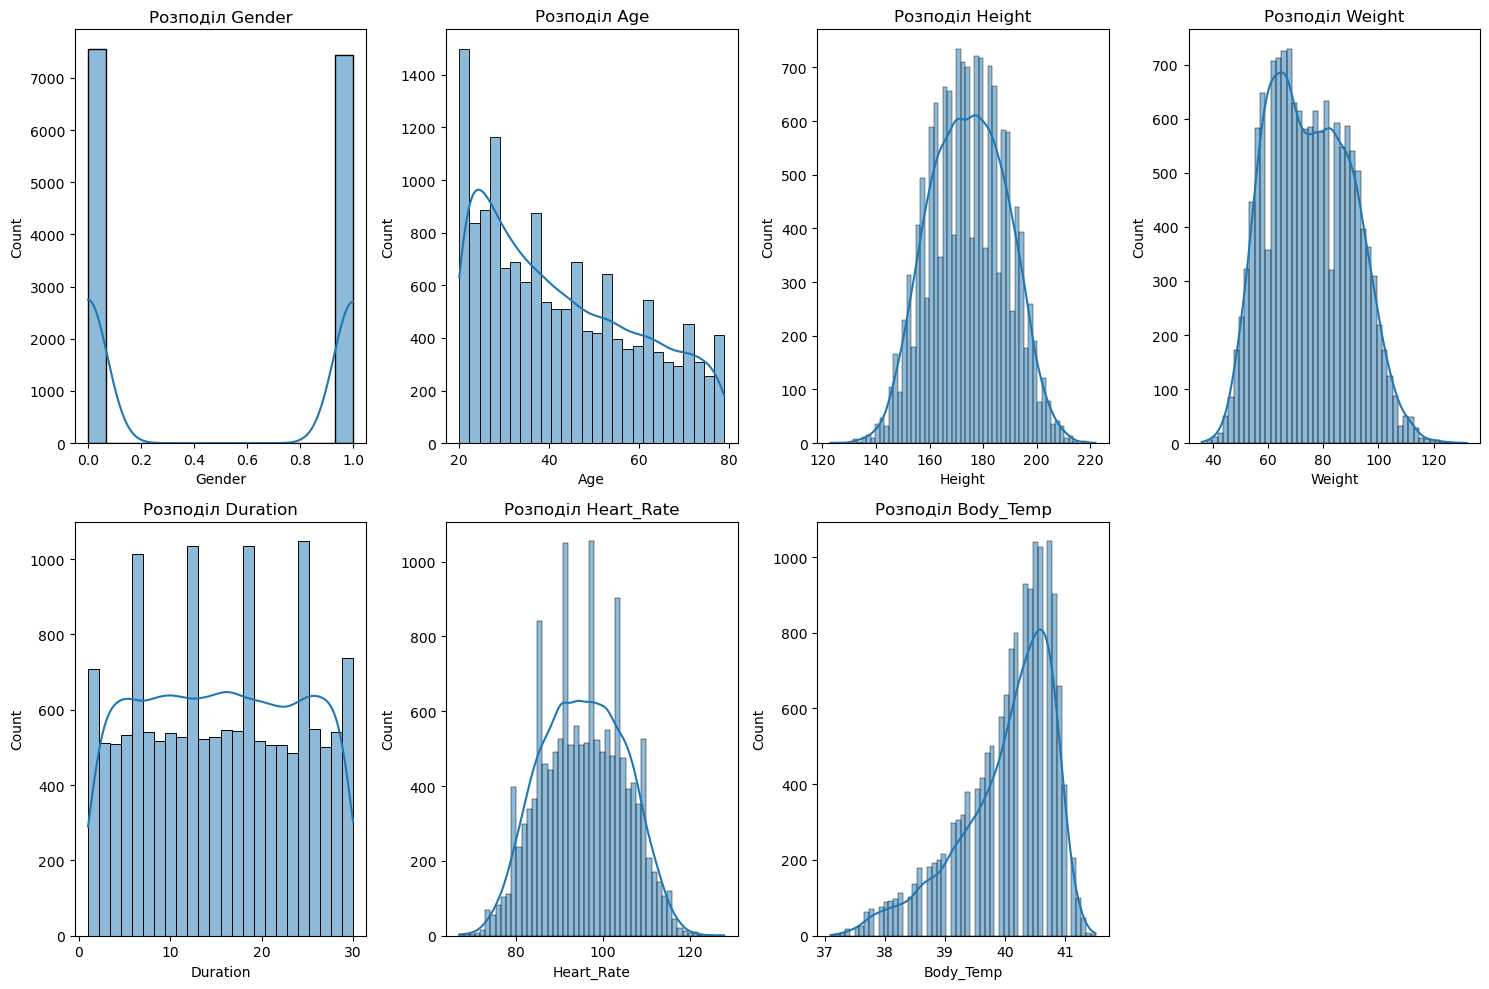

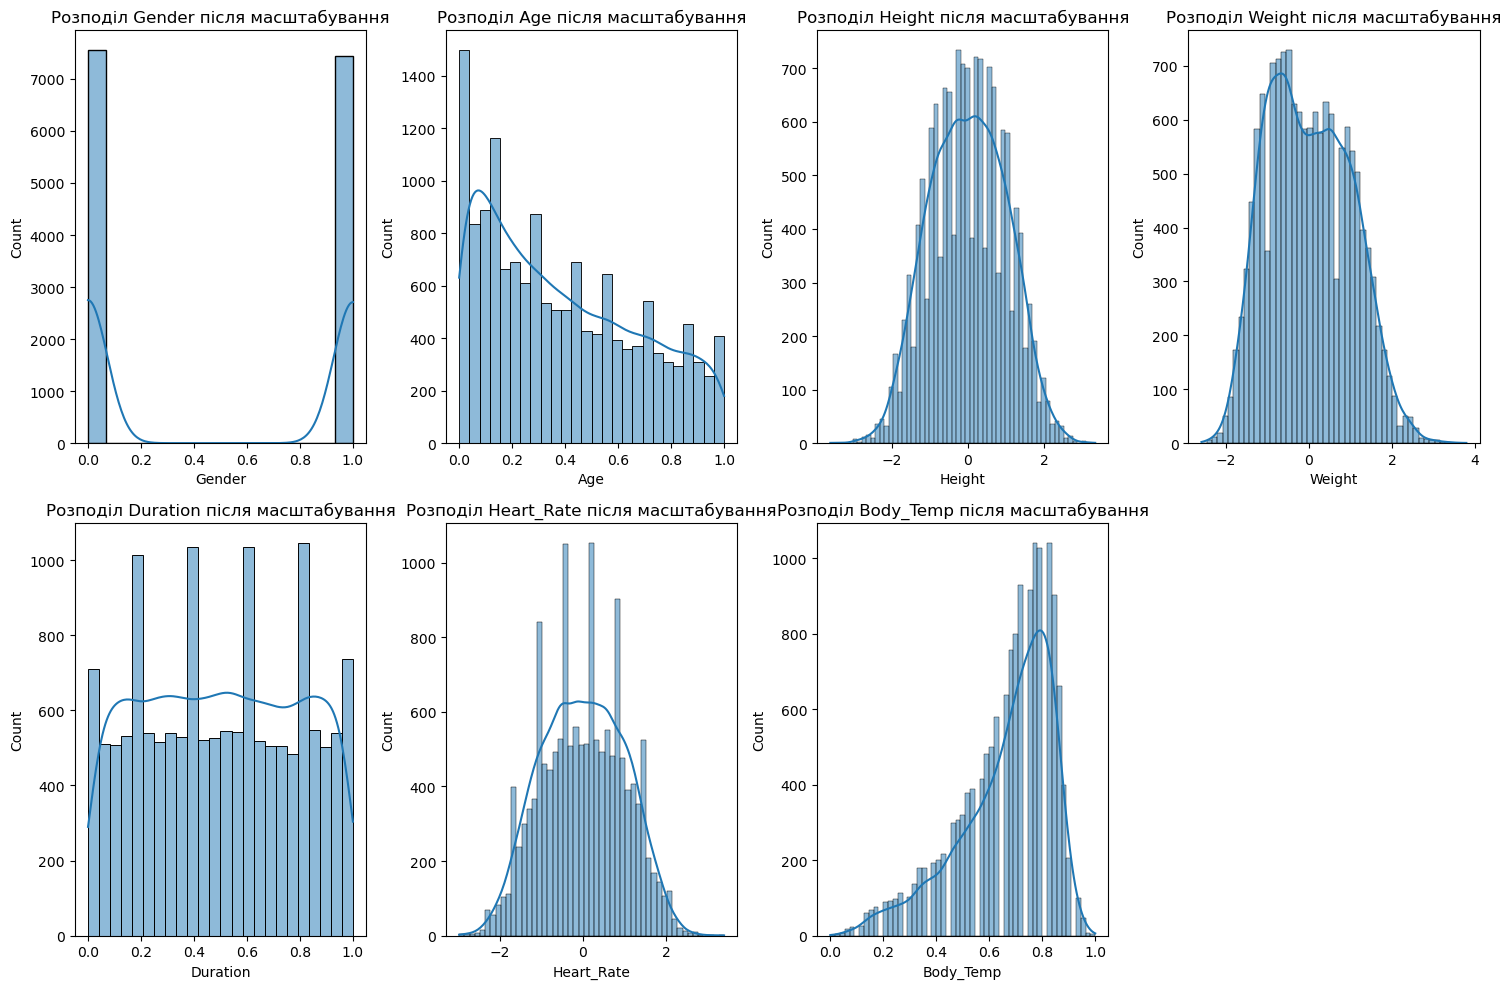

In [7]:
# Перевірка пропущених значень
print("Пропущені значення:\n", X.isnull().sum())

# Конвертація Gender у числовий формат
X['Gender'] = X['Gender'].map({'female': 0, 'male': 1})

# Вибір підходу до нормалізації
standard_features = ['Height', 'Weight', 'Heart_Rate']  # Нормальний розподіл
minmax_features = ['Age', 'Duration', 'Body_Temp']     # Асиметричний розподіл

# Масштабування для інших алгоритмів (окрім DBSCAN)
X_scaled = X.copy()
X_scaled[standard_features] = sp.StandardScaler().fit_transform(X[standard_features])
X_scaled[minmax_features] = sp.MinMaxScaler().fit_transform(X[minmax_features])

# Обґрунтування: StandardScaler для нормального розподілу, MinMaxScaler для асиметричних даних
print("Оновлені дані після масштабування (для KMeans, FCM, GMM):")
display(X_scaled.head())

# Графіки розподілу до масштабування
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(2, 4, i+1)
    sns.histplot(X[col], kde=True)
    plt.title(f'Розподіл {col}')
plt.tight_layout()
plt.show()

# Графіки розподілу після масштабування
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_scaled.columns):
    plt.subplot(2, 4, i+1)
    sns.histplot(X_scaled[col], kde=True)
    plt.title(f'Розподіл {col} після масштабування')
plt.tight_layout()
plt.show()

#### 2. Кластеризація у вихідному просторі (без зменшення розмірності)
* Утилітарна функція для кластеризації та метрик

In [9]:
def cluster_and_evaluate(X, method, n_clusters=3, eps=1.8, min_samples=10, tune_dbscan=False):
    X_np = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    if method == "KMeans":
        model = sc.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = model.fit_predict(X_np)
        centers = model.cluster_centers_
        metrics = {
            "Silhouette": smetrics.silhouette_score(X_np, labels),
            "Davies-Bouldin": smetrics.davies_bouldin_score(X_np, labels),
            "Calinski-Harabasz": smetrics.calinski_harabasz_score(X_np, labels),
            "Inertia": model.inertia_
        }
    elif method == "FuzzyCMeans":
        cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X_np.T, c=n_clusters, m=2, error=0.005, maxiter=1000, seed=42)
        labels = np.argmax(u, axis=0)
        centers = cntr
        metrics = {
            "Silhouette": smetrics.silhouette_score(X_np, labels),
            "FPC": fpc,
            "Xie-Beni": xie_beni(X_np, u, cntr),
            "Dunn": dunn_index(X_np, u, cntr),
            "Entropy": -np.sum(u * np.log(u + 1e-10)) / u.shape[1]
        }
    elif method == "GMM":
        model = sm.GaussianMixture(n_components=n_clusters, random_state=42)
        labels = model.fit_predict(X_np)
        centers = None
        metrics = {
            "Silhouette": smetrics.silhouette_score(X_np, labels),
            "BIC": model.bic(X_np),
            "AIC": model.aic(X_np)
        }
    elif method == "DBSCAN":
        if tune_dbscan:
            eps_values = np.arange(0.5, 4.0, 0.19)
            min_samples_values = range(3, 11)
            results = []
            for eps in eps_values:
                for min_samples in min_samples_values:
                    model = sc.DBSCAN(eps=eps, min_samples=min_samples)
                    labels = model.fit_predict(X_np)
                    mask = labels != -1
                    n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
                    if n_clusters_db >= 2:  # Вимагаємо мінімум 2 кластери
                        silhouette = smetrics.silhouette_score(X_np[mask], labels[mask])
                        results.append({
                            "eps": eps,
                            "min_samples": min_samples,
                            "Silhouette": silhouette,
                            "N_Clusters": n_clusters_db,
                            "N_Noise": sum(labels == -1),
                            "Davies-Bouldin": smetrics.davies_bouldin_score(X_np[mask], labels[mask]),
                            "Calinski-Harabasz": smetrics.calinski_harabasz_score(X_np[mask], labels[mask])
                        })
            if not results:
                print("Не вдалося знайти конфігурацію з >= 2 кластерами.")
                return None, None, {"Silhouette": -1, "N_Clusters": 1, "N_Noise": 0}
            df_results = pd.DataFrame(results)
            df_results["Score"] = (df_results["Silhouette"] * 0.5) + (df_results["N_Clusters"] / 10) - (df_results["N_Noise"] / X_np.shape[0])
            best_result = df_results.loc[df_results["Score"].idxmax()]
            eps, min_samples = best_result["eps"], int(best_result["min_samples"])
            print(f"\nНайкращі параметри для DBSCAN у цьому просторі:")
            display(best_result.round(4))
        
        model = sc.DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_np)
        centers = None
        mask = labels != -1
        n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
        metrics = {
            "Silhouette": smetrics.silhouette_score(X_np[mask], labels[mask]) if n_clusters_db > 1 else "N/A",
            "N_Clusters": n_clusters_db,
            "N_Noise": sum(labels == -1)
        }
        if n_clusters_db > 1:
            metrics["Davies-Bouldin"] = smetrics.davies_bouldin_score(X_np[mask], labels[mask])
            metrics["Calinski-Harabasz"] = smetrics.calinski_harabasz_score(X_np[mask], labels[mask])
    
    return labels, centers, metrics

def display_metrics(metrics, title):
    df_metrics = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
    # Округлення числових значень до 4 цифр після коми
    df_metrics["Value"] = df_metrics["Value"].apply(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)
    print(f"\n{title}:")
    # Форматування чисел без наукової нотації, з 4 цифрами після коми
    display(df_metrics.style.format({"Value": "{:.4f}"}, na_rep="N/A"))

def xie_beni(X, U, centers):
    C, N = U.shape  # U має форму (n_clusters, n_samples), тому C - кількість кластерів, N - кількість точок
    # Обчислення відстаней між точками і центрами
    dist = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2) ** 2  # (N, C)
    # Внутрішньокластерна відстань (зважуємо за U^2)
    intra = np.sum(U * dist.T)  # U вже має форму (C, N), dist.T має форму (C, N), тому множимо поелементно
    # Міжкластерна відстань (мінімальна відстань між центрами)
    inter_dist = ssd.cdist(centers, centers) ** 2  # (C, C)
    np.fill_diagonal(inter_dist, np.inf)  # Виключаємо діагональ (відстань між однаковими центрами)
    inter = np.min(inter_dist) + 1e-6  # Додаємо 1e-6, щоб уникнути ділення на 0
    # Індекс Xie-Beni
    return intra / (N * inter)

def dunn_index(X, U, centers):
    labels = np.argmax(U, axis=0)
    unique_labels = np.unique(labels)
    intra_distances = [np.max(ssd.cdist(X[labels == k], [centers[k]])) for k in unique_labels]
    inter_distances = ssd.cdist(centers, centers)
    np.fill_diagonal(inter_distances, np.inf)
    return np.min(inter_distances) / np.max(intra_distances)

# K-Means
def tune_km_clusters(X, cluster_range=range(2, 7)):
    results = []
    for n in cluster_range:
        km = sc.KMeans(n_clusters=n, random_state=42)
        labels = km.fit_predict(X)
        metrics = {
            "Silhouette": smetrics.silhouette_score(X, labels),
            "Inertia": km.inertia_
        }
        results.append({"Clusters": n, **metrics})
    return pd.DataFrame(results)

km_tuning = tune_km_clusters(X_scaled)
best_n_clusters_km = int(km_tuning.loc[km_tuning["Inertia"].idxmin()]["Clusters"])
print(f"Найкраща кількість кластерів для K-Means: {best_n_clusters_km}")
display(km_tuning.round(4))

km = sc.KMeans(n_clusters=best_n_clusters_km, random_state=42)
labels_km = km.fit_predict(X_scaled)
centers_km = km.cluster_centers_
metrics_km = {
    "Silhouette": smetrics.silhouette_score(X_scaled, labels_km),
    "Inertia": km.inertia_
}
display_metrics(metrics_km, "K-Means Metrics (Optimized)")

# Fuzzy C-Means
def tune_fcm_clusters(X, cluster_range=range(2, 7)):
    results = []
    for n in cluster_range:
        cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X.to_numpy().T, c=n, m=2, error=0.005, maxiter=1000, seed=42)
        labels = np.argmax(u, axis=0)
        metrics = {
            "Silhouette": smetrics.silhouette_score(X, labels),
            "FPC": fpc,
            "Xie-Beni": xie_beni(X.to_numpy(), u, cntr),
            "Dunn": dunn_index(X.to_numpy(), u, cntr),
            "Entropy": -np.sum(u * np.log(u + 1e-10)) / u.shape[1]
        }
        results.append({"Clusters": n, **metrics})
    return pd.DataFrame(results)

def tune_fcm_m(X, m_values=[1.5, 1.8, 2.0, 2.5, 3.0], n_clusters=3):
    results = []
    for m in m_values:
        cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X.to_numpy().T, c=n_clusters, m=m, error=0.005, maxiter=1000, seed=42)
        labels = np.argmax(u, axis=0)
        metrics = {
            "Silhouette": smetrics.silhouette_score(X, labels),
            "FPC": fpc,
            "Xie-Beni": xie_beni(X.to_numpy(), u, cntr),
            "Dunn": dunn_index(X.to_numpy(), u, cntr),
            "Entropy": -np.sum(u * np.log(u + 1e-10)) / u.shape[1]
        }
        results.append({"m": m, **metrics})
    return pd.DataFrame(results)

fcm_tuning = tune_fcm_clusters(X_scaled)
best_n_clusters_fcm = int(fcm_tuning.loc[fcm_tuning["Xie-Beni"].idxmin()]["Clusters"])
print(f"Найкраща кількість кластерів для Fuzzy C-Means: {best_n_clusters_fcm}")
display(fcm_tuning.round(4))

fcm_m_tuning = tune_fcm_m(X_scaled, n_clusters=best_n_clusters_fcm)
best_m = fcm_m_tuning.loc[fcm_m_tuning["Xie-Beni"].idxmin()]["m"]
print(f"Найкраще значення m: {best_m:.4f}")
display(fcm_m_tuning.round(4))

cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X_scaled.to_numpy().T, c=best_n_clusters_fcm, m=best_m, error=0.005, maxiter=1000, seed=42)
labels_fcm = np.argmax(u, axis=0)
centers_fcm = cntr
metrics_fcm = {
    "Silhouette": smetrics.silhouette_score(X_scaled, labels_fcm),
    "FPC": fpc,
    "Xie-Beni": xie_beni(X_scaled.to_numpy(), u, cntr),
    "Dunn": dunn_index(X_scaled.to_numpy(), u, cntr),
    "Entropy": -np.sum(u * np.log(u + 1e-10)) / u.shape[1]
}
display_metrics(metrics_fcm, "Fuzzy C-Means Metrics (Optimized)")

# GMM
def tune_gmm_clusters(X, cluster_range=range(2, 7)):
    results = []
    for n in cluster_range:
        gmm = sm.GaussianMixture(n_components=n, random_state=42)
        labels = gmm.fit_predict(X)
        metrics = {
            "Silhouette": smetrics.silhouette_score(X, labels),
            "BIC": gmm.bic(X)
        }
        results.append({"Clusters": n, **metrics})
    return pd.DataFrame(results)

gmm_tuning = tune_gmm_clusters(X_scaled)
best_n_clusters_gmm = int(gmm_tuning.loc[gmm_tuning["BIC"].idxmin()]["Clusters"])
print(f"Найкраща кількість кластерів для GMM: {best_n_clusters_gmm}")
display(gmm_tuning.round(4))

gmm = sm.GaussianMixture(n_components=best_n_clusters_gmm, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
metrics_gmm = {
    "Silhouette": smetrics.silhouette_score(X_scaled, labels_gmm),
    "BIC": gmm.bic(X_scaled)
}
display_metrics(metrics_gmm, "GMM Metrics (Optimized)")

# DBSCAN
def tune_dbscan(X, eps_values=[0.3, 0.5, 0.7], min_samples_values=[3, 5, 7]):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = sc.DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            if len(np.unique(labels)) > 1:  # Перевірка, чи є кластери
                silhouette = smetrics.silhouette_score(X, labels)
            else:
                silhouette = -1  # Якщо кластери не знайдені
            results.append({"eps": eps, "min_samples": min_samples, "Silhouette": silhouette})
    return pd.DataFrame(results)

dbscan_tuning = tune_dbscan(X_scaled)
best_params = dbscan_tuning.loc[dbscan_tuning["Silhouette"].idxmax()]
best_eps = best_params["eps"]
best_min_samples = int(best_params["min_samples"])
print(f"Найкращі параметри для DBSCAN: eps={best_eps:.4f}, min_samples={best_min_samples}")
display(dbscan_tuning.round(4))

dbscan = sc.DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)
if len(np.unique(labels_dbscan)) > 1:
    metrics_dbscan = {
        "Silhouette": smetrics.silhouette_score(X_scaled, labels_dbscan)
    }
else:
    metrics_dbscan = {
        "Silhouette": -1
    }
display_metrics(metrics_dbscan, "DBSCAN Metrics (Optimized)")

Найкраща кількість кластерів для K-Means: 6


,Clusters,Silhouette,Inertia
0,2,0.3783,28876.4872
1,3,0.3251,22797.0507
2,4,0.3001,17557.5681
3,5,0.2867,15059.3424
4,6,0.2703,13313.1266



K-Means Metrics (Optimized):


,Metric,Value
0,Silhouette,0.2703
1,Inertia,13313.1266


Найкраща кількість кластерів для Fuzzy C-Means: 2


,Clusters,Silhouette,FPC,Xie-Beni,Dunn,Entropy
0,2,0.3783,0.7083,0.5034,0.6063,0.4550
1,3,0.3235,0.5611,1.1196,0.4249,0.7632
2,4,0.3000,0.4986,1.1184,0.4137,0.9447
3,5,0.2845,0.4300,1.1330,0.4051,1.1373
4,6,0.2674,0.3886,1.8514,0.3325,1.2766


Найкраще значення m: 1.5000


,m,Silhouette,FPC,Xie-Beni,Dunn,Entropy
0,1.5,0.3783,0.8563,0.3606,0.6392,0.2423
1,1.8,0.3783,0.7605,0.4428,0.6220,0.3850
2,2.0,0.3783,0.7083,0.5034,0.6063,0.4550
3,2.5,0.3783,0.6206,0.6499,0.5649,0.5629
4,3.0,0.3784,0.5735,0.7805,0.5275,0.6161



Fuzzy C-Means Metrics (Optimized):


,Metric,Value
0,Silhouette,0.3783
1,FPC,0.8563
2,Xie-Beni,0.3606
3,Dunn,0.6392
4,Entropy,0.2423


Найкраща кількість кластерів для GMM: 4


,Clusters,Silhouette,BIC
0,2,0.3444,-130012.6655
1,3,0.2571,-136484.1338
2,4,0.1986,-143410.7835
3,5,0.1911,-143247.0399
4,6,0.1356,-142906.7425



GMM Metrics (Optimized):


,Metric,Value
0,Silhouette,0.1986
1,BIC,-143410.7835


Найкращі параметри для DBSCAN: eps=0.7000, min_samples=7


,eps,min_samples,Silhouette
0,0.3,3,-0.3648
1,0.3,5,-0.2817
2,0.3,7,-0.2442
3,0.5,3,0.2137
4,0.5,5,0.1650
5,0.5,7,0.3403
6,0.7,3,0.3396
7,0.7,5,0.3413
8,0.7,7,0.3416



DBSCAN Metrics (Optimized):


,Metric,Value
0,Silhouette,0.3416


#### 2.1 K-Means

In [11]:
labels_km, centers_km, metrics_km = cluster_and_evaluate(X_scaled, "KMeans")
display_metrics(metrics_km, "K-Means Metrics")


K-Means Metrics:


,Metric,Value
0,Silhouette,0.3261
1,Davies-Bouldin,1.0664
2,Calinski-Harabasz,9847.4470
3,Inertia,22348.1831


#### 2.2 Fuzzy C-Means

In [13]:
# Підбір кількості кластерів
fcm_tuning = tune_fcm_clusters(X_scaled)
best_n_clusters = int(fcm_tuning.loc[fcm_tuning["Xie-Beni"].idxmin()]["Clusters"])
print(f"Найкраща кількість кластерів: {best_n_clusters}")
# Округлюємо всі числові стовпці до 4 цифр після коми
display(fcm_tuning.round(4))

# Підбір параметра m
fcm_m_tuning = tune_fcm_m(X_scaled, n_clusters=best_n_clusters)
best_m = fcm_m_tuning.loc[fcm_m_tuning["Xie-Beni"].idxmin()]["m"]
print(f"Найкраще значення m: {best_m:.4f}")  # Форматуємо best_m до 4 цифр
# Округлюємо всі числові стовпці до 4 цифр після коми
display(fcm_m_tuning.round(4))

# Кластеризація з найкращими параметрами
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X_scaled.to_numpy().T, c=best_n_clusters, m=best_m, error=0.005, maxiter=1000, seed=42)
labels_fcm = np.argmax(u, axis=0)
centers_fcm = cntr
metrics_fcm = {
    "Silhouette": smetrics.silhouette_score(X_scaled, labels_fcm),
    "FPC": fpc,
    "Xie-Beni": xie_beni(X_scaled.to_numpy(), u, cntr),
    "Dunn": dunn_index(X_scaled.to_numpy(), u, cntr),
    "Entropy": -np.sum(u * np.log(u + 1e-10)) / u.shape[1]
}
display_metrics(metrics_fcm, "Fuzzy C-Means Metrics (Optimized)")

Найкраща кількість кластерів: 2


,Clusters,Silhouette,FPC,Xie-Beni,Dunn,Entropy
0,2,0.3783,0.7083,0.5034,0.6063,0.4550
1,3,0.3235,0.5611,1.1196,0.4249,0.7632
2,4,0.3000,0.4986,1.1184,0.4137,0.9447
3,5,0.2845,0.4300,1.1330,0.4051,1.1373
4,6,0.2674,0.3886,1.8514,0.3325,1.2766


Найкраще значення m: 1.5000


,m,Silhouette,FPC,Xie-Beni,Dunn,Entropy
0,1.5,0.3783,0.8563,0.3606,0.6392,0.2423
1,1.8,0.3783,0.7605,0.4428,0.6220,0.3850
2,2.0,0.3783,0.7083,0.5034,0.6063,0.4550
3,2.5,0.3783,0.6206,0.6499,0.5649,0.5629
4,3.0,0.3784,0.5735,0.7805,0.5275,0.6161



Fuzzy C-Means Metrics (Optimized):


,Metric,Value
0,Silhouette,0.3783
1,FPC,0.8563
2,Xie-Beni,0.3606
3,Dunn,0.6392
4,Entropy,0.2423


#### 2.3 Gaussian Mixture Models (GMM)

In [15]:
labels_gmm, _, metrics_gmm = cluster_and_evaluate(X_scaled, "GMM")
display_metrics(metrics_gmm, "GMM Metrics")


GMM Metrics:


,Metric,Value
0,Silhouette,0.2571
1,BIC,-136484.1338
2,AIC,-137299.0249


#### 2.4 DBSCAN

In [17]:
labels_dbscan, _, metrics_dbscan = cluster_and_evaluate(X, "DBSCAN", tune_dbscan=True)
display_metrics(metrics_dbscan, "DBSCAN Metrics (Original Space)")


Найкращі параметри для DBSCAN у цьому просторі:


eps                     3.1600
min_samples             3.0000
Silhouette              0.1065
N_Clusters            821.0000
N_Noise              9716.0000
Davies-Bouldin          0.9653
Calinski-Harabasz     105.5091
Score                  81.5055
Name: 28, dtype: float64


DBSCAN Metrics (Original Space):


,Metric,Value
0,Silhouette,0.1065
1,N_Clusters,821.0000
2,N_Noise,9716.0000
3,Davies-Bouldin,0.9653
4,Calinski-Harabasz,105.5091


#### 3. Зменшення розмірності за допомогою PCA (до 2-3 компонент)
#### 3.1 Застосування PCA

In [19]:
pca_2 = sd.PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)
print("Пояснена дисперсія (2 компоненти):", pca_2.explained_variance_ratio_ * 100)

pca_3 = sd.PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)
print("Пояснена дисперсія (3 компоненти):", pca_3.explained_variance_ratio_ * 100)

Пояснена дисперсія (2 компоненти): [61.18585349 31.36091363]
Пояснена дисперсія (3 компоненти): [61.18585349 31.36091363  3.16210202]


#### 3.2 Повторна кластеризація

In [21]:
# K-Means
labels_km_pca2, centers_km_pca2, metrics_km_pca2 = cluster_and_evaluate(X_pca_2, "KMeans")
labels_km_pca3, centers_km_pca3, metrics_km_pca3 = cluster_and_evaluate(X_pca_3, "KMeans")
display_metrics(metrics_km_pca2, "K-Means PCA 2")
display_metrics(metrics_km_pca3, "K-Means PCA 3")

# Fuzzy C-Means
labels_fcm_pca2, centers_fcm_pca2, metrics_fcm_pca2 = cluster_and_evaluate(X_pca_2, "FuzzyCMeans")
labels_fcm_pca3, centers_fcm_pca3, metrics_fcm_pca3 = cluster_and_evaluate(X_pca_3, "FuzzyCMeans")
display_metrics(metrics_fcm_pca2, "Fuzzy C-Means PCA 2")
display_metrics(metrics_fcm_pca3, "Fuzzy C-Means PCA 3")

# GMM
labels_gmm_pca2, _, metrics_gmm_pca2 = cluster_and_evaluate(X_pca_2, "GMM")
labels_gmm_pca3, _, metrics_gmm_pca3 = cluster_and_evaluate(X_pca_3, "GMM")
display_metrics(metrics_gmm_pca2, "GMM PCA 2")
display_metrics(metrics_gmm_pca3, "GMM PCA 3")

# DBSCAN
labels_dbscan_pca2, _, metrics_dbscan_pca2 = cluster_and_evaluate(X_pca_2, "DBSCAN", tune_dbscan=True)
labels_dbscan_pca3, _, metrics_dbscan_pca3 = cluster_and_evaluate(X_pca_3, "DBSCAN", tune_dbscan=True)
display_metrics(metrics_dbscan_pca2, "DBSCAN PCA 2")
display_metrics(metrics_dbscan_pca3, "DBSCAN PCA 3")


K-Means PCA 2:


,Metric,Value
0,Silhouette,0.3702
1,Davies-Bouldin,0.9322
2,Calinski-Harabasz,11835.3103
3,Inertia,18556.1981



K-Means PCA 3:


,Metric,Value
0,Silhouette,0.3546
1,Davies-Bouldin,0.9877
2,Calinski-Harabasz,10930.8839
3,Inertia,20131.9040



Fuzzy C-Means PCA 2:


,Metric,Value
0,Silhouette,0.3686
1,FPC,0.6104
2,Xie-Beni,0.8464
3,Dunn,0.4698
4,Entropy,0.6853



Fuzzy C-Means PCA 3:


,Metric,Value
0,Silhouette,0.3526
1,FPC,0.5937
2,Xie-Beni,0.9467
3,Dunn,0.4461
4,Entropy,0.7115



GMM PCA 2:


,Metric,Value
0,Silhouette,0.3660
1,BIC,96202.8821
2,AIC,96073.4134



GMM PCA 3:


,Metric,Value
0,Silhouette,0.3152
1,BIC,65474.3191
2,AIC,65253.4607


Не вдалося знайти конфігурацію з >= 2 кластерами.

Найкращі параметри для DBSCAN у цьому просторі:


eps                      0.6900
min_samples              3.0000
Silhouette               0.3663
N_Clusters               2.0000
N_Noise                  2.0000
Davies-Bouldin           1.0722
Calinski-Harabasz    10638.1567
Score                    0.3830
Name: 8, dtype: float64


DBSCAN PCA 2:


,Metric,Value
0,Silhouette,-1.0000
1,N_Clusters,1.0000
2,N_Noise,0.0000



DBSCAN PCA 3:


,Metric,Value
0,Silhouette,0.3663
1,N_Clusters,2.0000
2,N_Noise,2.0000
3,Davies-Bouldin,1.0722
4,Calinski-Harabasz,10638.1567


#### 4. Зменшення розмірності за допомогою PCA (до 4-5 компонент)
#### 4.1 Розширене зменшення розмірності

In [23]:
pca_4 = sd.PCA(n_components=4)
X_pca_4 = pca_4.fit_transform(X_scaled)
print("Пояснена дисперсія (4 компоненти):", pca_4.explained_variance_ratio_ * 100)

pca_5 = sd.PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)
print("Пояснена дисперсія (5 компонент):", pca_5.explained_variance_ratio_ * 100)

Пояснена дисперсія (4 компоненти): [61.18585349 31.36091363  3.16210202  2.54927187]
Пояснена дисперсія (5 компонент): [61.18585349 31.36091363  3.16210202  2.54927187  0.83097498]


#### 4.2 Кластеризація

In [25]:
# K-Means
labels_km_pca4, centers_km_pca4, metrics_km_pca4 = cluster_and_evaluate(X_pca_4, "KMeans")
labels_km_pca5, centers_km_pca5, metrics_km_pca5 = cluster_and_evaluate(X_pca_5, "KMeans")
display_metrics(metrics_km_pca4, "K-Means PCA 4")
display_metrics(metrics_km_pca5, "K-Means PCA 5")

# Fuzzy C-Means
labels_fcm_pca4, centers_fcm_pca4, metrics_fcm_pca4 = cluster_and_evaluate(X_pca_4, "FuzzyCMeans")
labels_fcm_pca5, centers_fcm_pca5, metrics_fcm_pca5 = cluster_and_evaluate(X_pca_5, "FuzzyCMeans")
display_metrics(metrics_fcm_pca4, "Fuzzy C-Means PCA 4")
display_metrics(metrics_fcm_pca5, "Fuzzy C-Means PCA 5")

# GMM
labels_gmm_pca4, _, metrics_gmm_pca4 = cluster_and_evaluate(X_pca_4, "GMM")
labels_gmm_pca5, _, metrics_gmm_pca5 = cluster_and_evaluate(X_pca_5, "GMM")
display_metrics(metrics_gmm_pca4, "GMM PCA 4")
display_metrics(metrics_gmm_pca5, "GMM PCA 5")

# DBSCAN
labels_dbscan_pca4, _, metrics_dbscan_pca4 = cluster_and_evaluate(X_pca_4, "DBSCAN", tune_dbscan=True)
labels_dbscan_pca5, _, metrics_dbscan_pca5 = cluster_and_evaluate(X_pca_5, "DBSCAN", tune_dbscan=True)
display_metrics(metrics_dbscan_pca4, "DBSCAN PCA 4")
display_metrics(metrics_dbscan_pca5, "DBSCAN PCA 5")


K-Means PCA 4:


,Metric,Value
0,Silhouette,0.3369
1,Davies-Bouldin,1.0368
2,Calinski-Harabasz,10259.5537
3,Inertia,21449.3395



K-Means PCA 5:


,Metric,Value
0,Silhouette,0.3315
1,Davies-Bouldin,1.0509
2,Calinski-Harabasz,10059.2564
3,Inertia,21877.4739



Fuzzy C-Means PCA 4:


,Metric,Value
0,Silhouette,0.3346
1,FPC,0.5738
2,Xie-Beni,1.0473
3,Dunn,0.4356
4,Entropy,0.7433



Fuzzy C-Means PCA 5:


,Metric,Value
0,Silhouette,0.3290
1,FPC,0.5675
2,Xie-Beni,1.0796
3,Dunn,0.4326
4,Entropy,0.7533



GMM PCA 4:


,Metric,Value
0,Silhouette,0.2989
1,BIC,64612.1274
2,AIC,64277.0320



GMM PCA 5:


,Metric,Value
0,Silhouette,0.2809
1,BIC,53276.5456
2,AIC,52804.3657



Найкращі параметри для DBSCAN у цьому просторі:


eps                      0.6900
min_samples              3.0000
Silhouette               0.3531
N_Clusters               2.0000
N_Noise                  6.0000
Davies-Bouldin           1.1085
Calinski-Harabasz    10190.5302
Score                    0.3762
Name: 8, dtype: float64


Найкращі параметри для DBSCAN у цьому просторі:


eps                     0.5000
min_samples             7.0000
Silhouette              0.2882
N_Clusters              3.0000
N_Noise                52.0000
Davies-Bouldin          0.9217
Calinski-Harabasz    5095.5056
Score                   0.4406
Name: 4, dtype: float64


DBSCAN PCA 4:


,Metric,Value
0,Silhouette,0.3531
1,N_Clusters,2.0000
2,N_Noise,6.0000
3,Davies-Bouldin,1.1085
4,Calinski-Harabasz,10190.5302



DBSCAN PCA 5:


,Metric,Value
0,Silhouette,0.2882
1,N_Clusters,3.0000
2,N_Noise,52.0000
3,Davies-Bouldin,0.9217
4,Calinski-Harabasz,5095.5056


#### 5. Візуалізація результатів
#### 5.1 Графічне порівняння (2D для PCA 2, 3D для PCA 3)

C:\Temp\ipykernel_7920\2869918066.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)


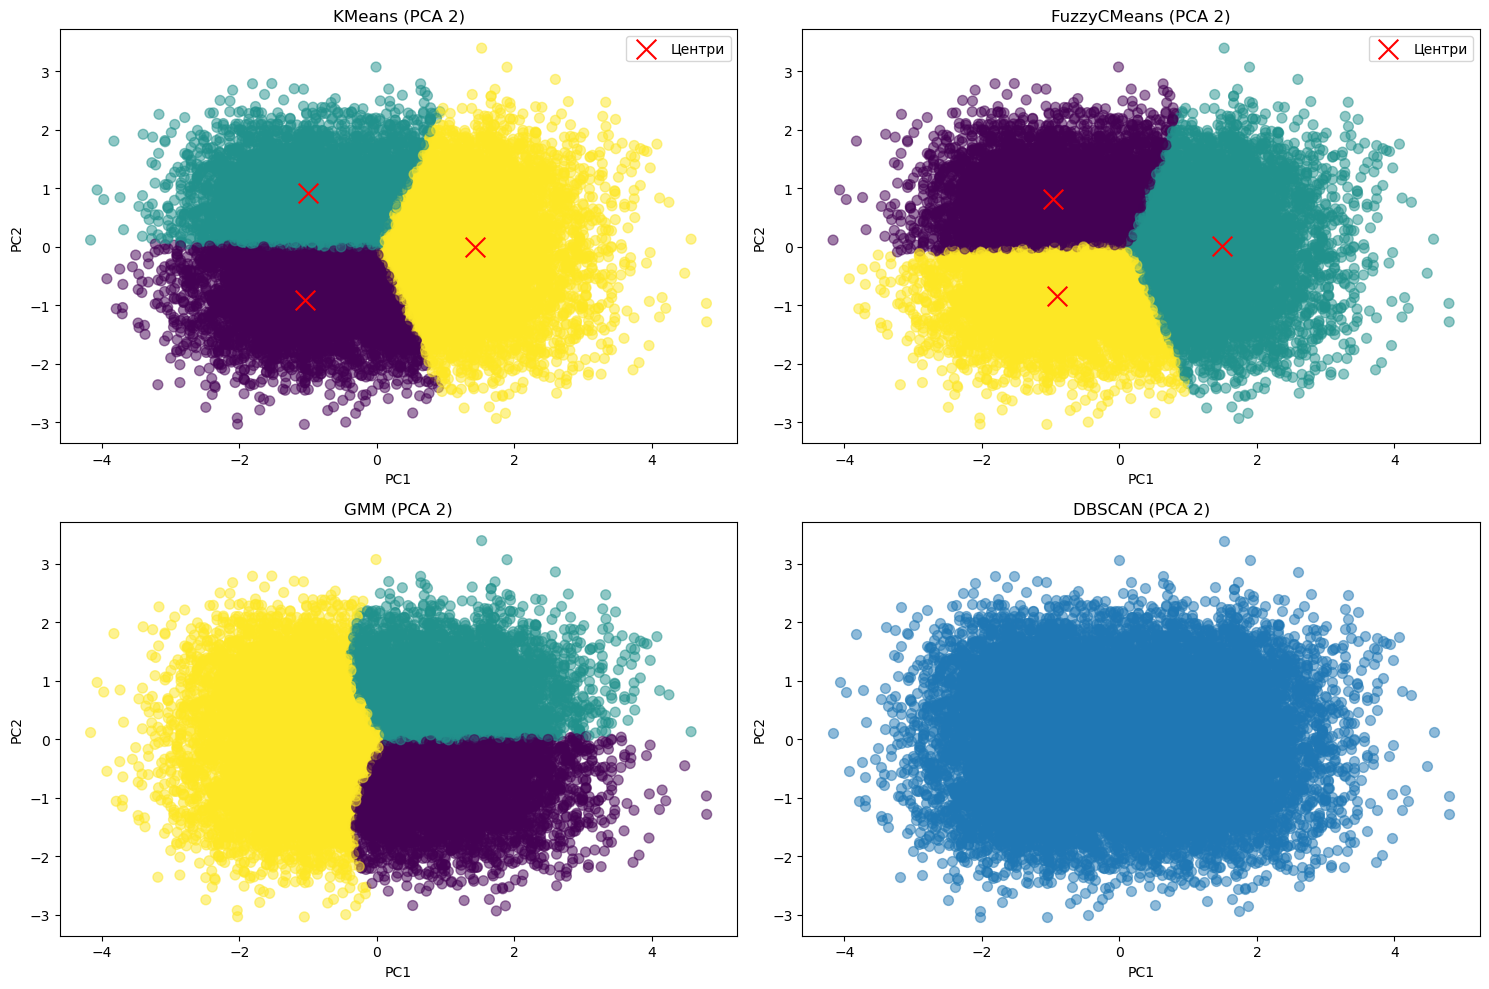

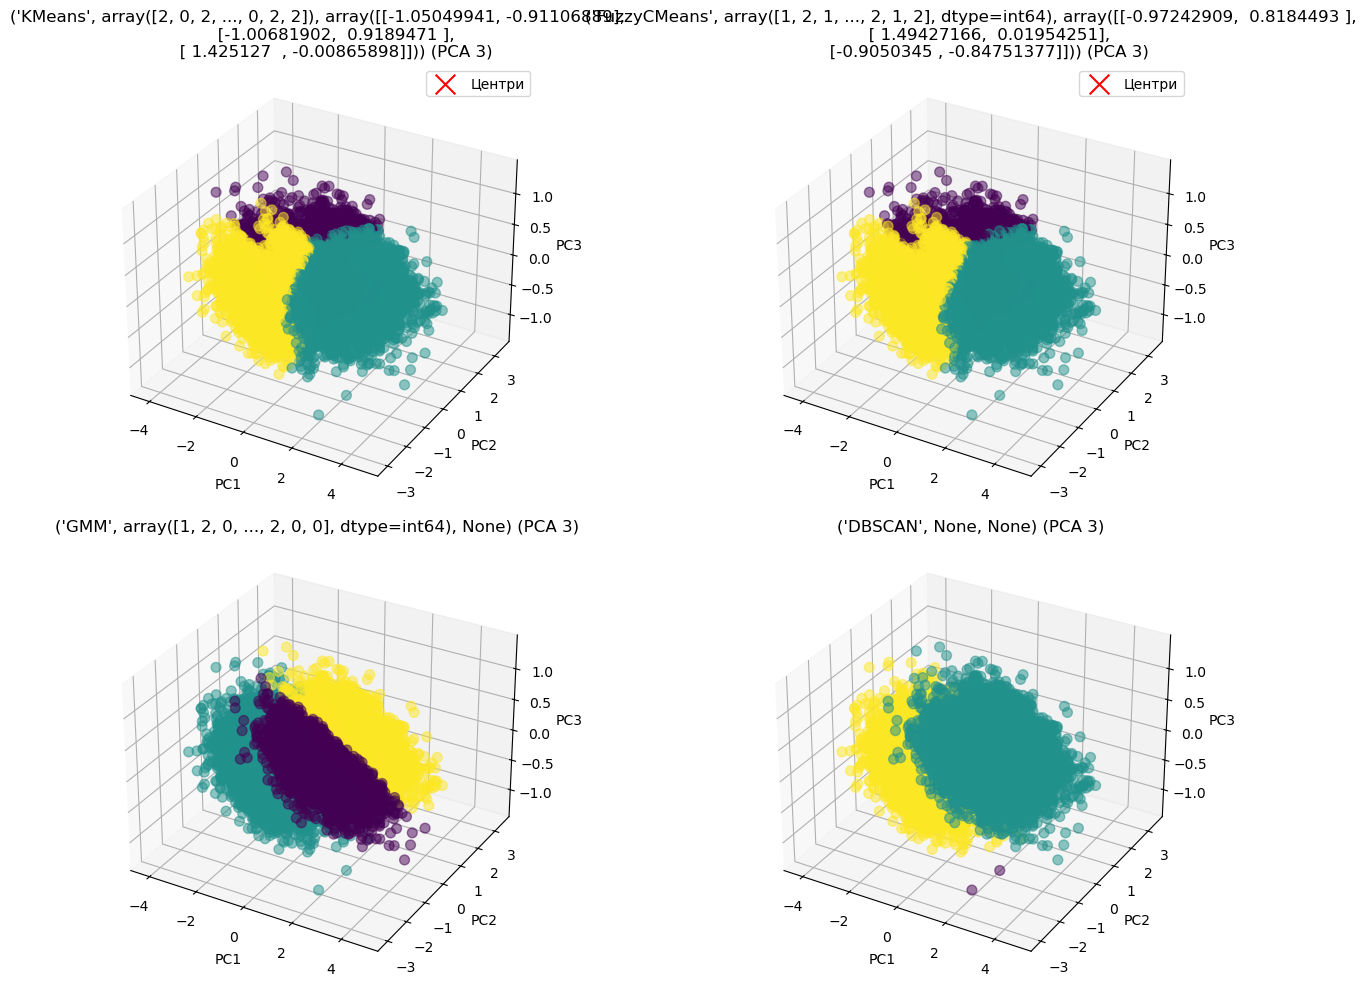

In [27]:
# 2D для PCA 2
methods = [("KMeans", labels_km_pca2, centers_km_pca2), 
           ("FuzzyCMeans", labels_fcm_pca2, centers_fcm_pca2), 
           ("GMM", labels_gmm_pca2, None), 
           ("DBSCAN", labels_dbscan_pca2, None)]

plt.figure(figsize=(15, 10))
for i, (method, labels, centers) in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Центри')
        plt.legend()
    plt.title(f"{method} (PCA 2)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 3D для PCA 3
fig = plt.figure(figsize=(15, 10))
for i, (method, labels, centers) in enumerate([(m, l, c) for m, l, c in zip(methods, 
           [labels_km_pca3, labels_fcm_pca3, labels_gmm_pca3, labels_dbscan_pca3], 
           [centers_km_pca3, centers_fcm_pca3, None, None])], 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=labels, cmap='viridis', s=50, alpha=0.5)
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=200, label='Центри')
        ax.legend()
    ax.set_title(f"{method} (PCA 3)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

#### 5.2 Зіставлення до та після PCA

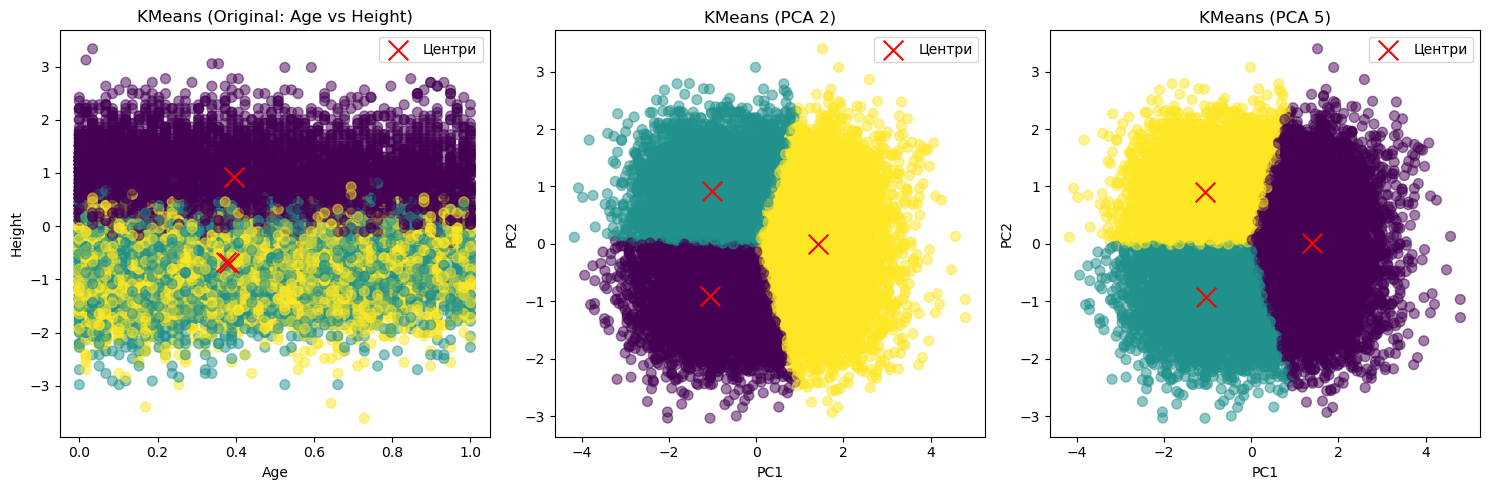

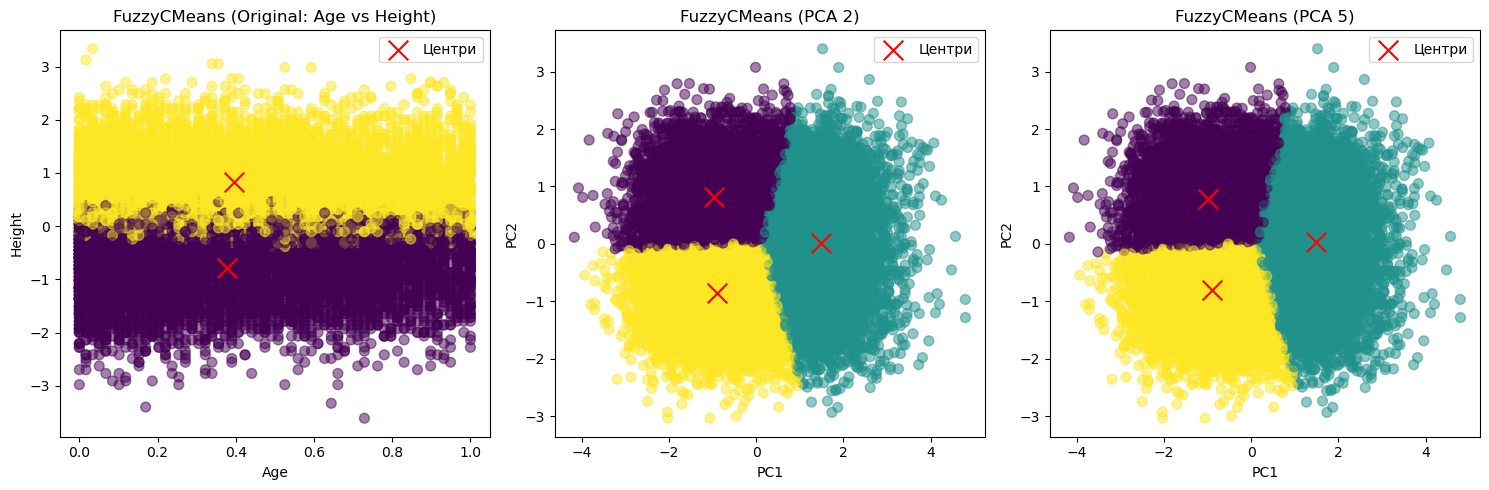

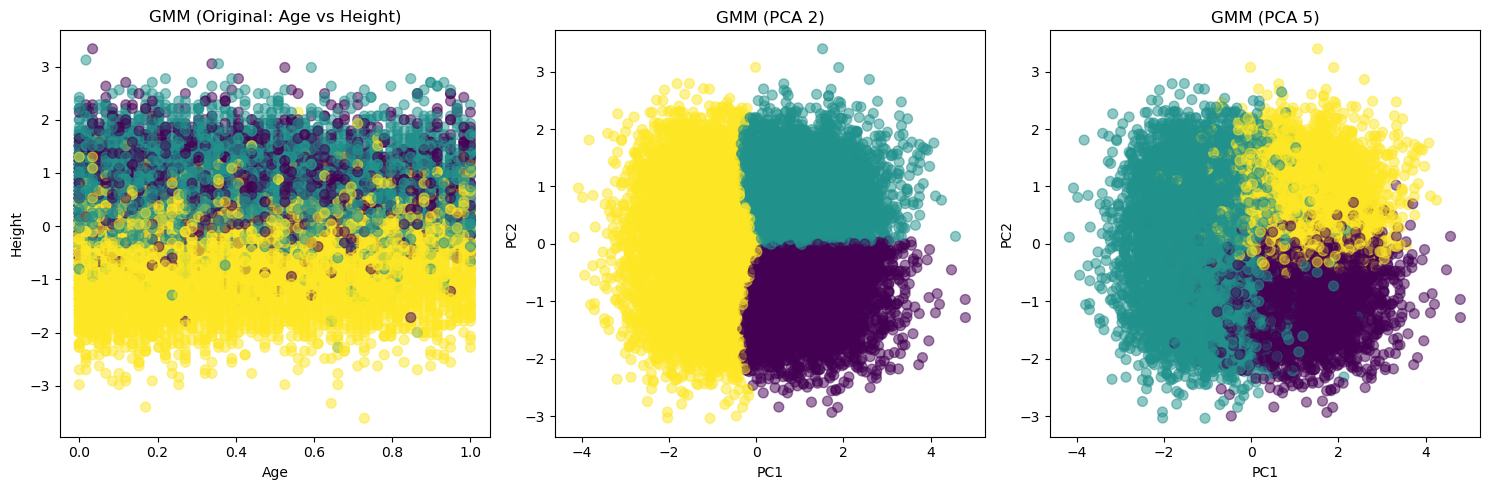

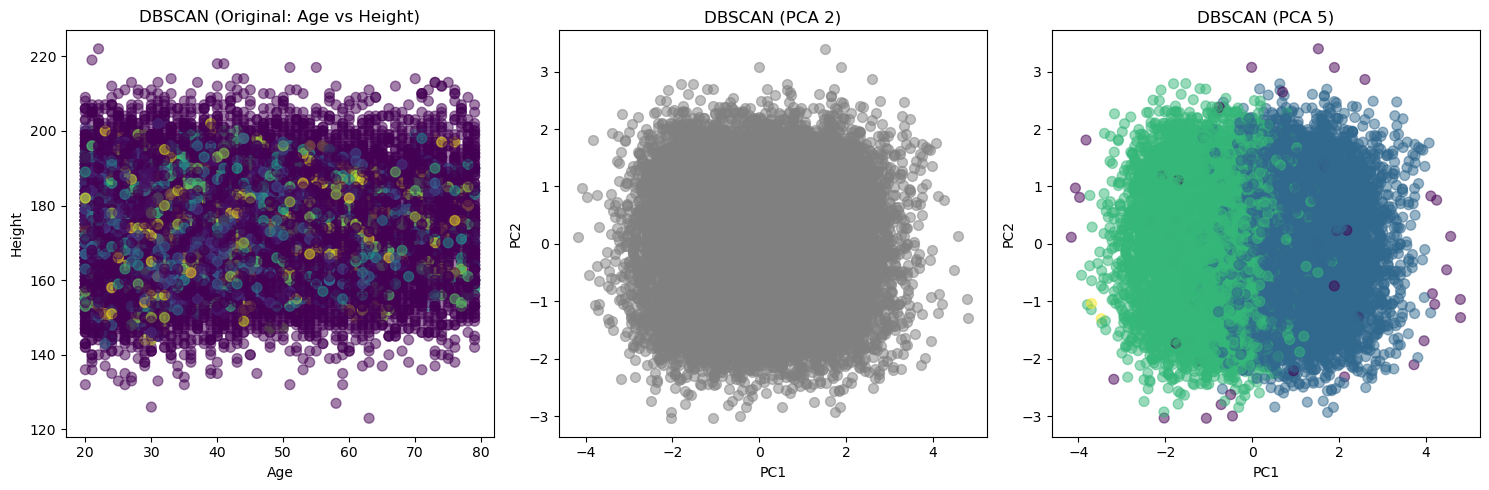

In [29]:
X_original_np = X_scaled.to_numpy()
X_raw_np = X.to_numpy()

# Переконайся, що всі мітки і центри визначені
methods_full = [
    ("KMeans", labels_km, centers_km, labels_km_pca2, centers_km_pca2, labels_km_pca5, centers_km_pca5),
    ("FuzzyCMeans", labels_fcm, centers_fcm, labels_fcm_pca2, centers_fcm_pca2, labels_fcm_pca5, centers_fcm_pca5),
    ("GMM", labels_gmm, None, labels_gmm_pca2, None, labels_gmm_pca5, None),
    ("DBSCAN", labels_dbscan, None, labels_dbscan_pca2, None, labels_dbscan_pca5, None)
]

for method, orig_labels, orig_centers, pca2_labels, pca2_centers, pca5_labels, pca5_centers in methods_full:
    plt.figure(figsize=(15, 5))
    
    # Вихідний простір (Age vs Height)
    data = X_raw_np if method == "DBSCAN" else X_original_np
    centers_data = orig_centers[:, [1, 2]] if orig_centers is not None and method != "DBSCAN" else orig_centers
    plt.subplot(1, 3, 1)
    if orig_labels is not None and len(np.unique(orig_labels)) > 1:  # Перевірка на наявність міток і різних кластерів
        plt.scatter(data[:, 1], data[:, 2], c=orig_labels, cmap='viridis', s=50, alpha=0.5)
    else:
        plt.scatter(data[:, 1], data[:, 2], c='gray', s=50, alpha=0.5)  # Якщо міток немає, всі точки сірі
    if centers_data is not None:
        plt.scatter(centers_data[:, 0], centers_data[:, 1], c='red', marker='x', s=200, label='Центри')
        plt.legend()
    plt.title(f"{method} (Original: Age vs Height)")
    plt.xlabel("Age")
    plt.ylabel("Height")

    # PCA 2
    plt.subplot(1, 3, 2)
    if pca2_labels is not None and len(np.unique(pca2_labels)) > 1:
        plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=pca2_labels, cmap='viridis', s=50, alpha=0.5)
    else:
        plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c='gray', s=50, alpha=0.5)
    if pca2_centers is not None:
        plt.scatter(pca2_centers[:, 0], pca2_centers[:, 1], c='red', marker='x', s=200, label='Центри')
        plt.legend()
    plt.title(f"{method} (PCA 2)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # PCA 5
    plt.subplot(1, 3, 3)
    if pca5_labels is not None and len(np.unique(pca5_labels)) > 1:
        plt.scatter(X_pca_5[:, 0], X_pca_5[:, 1], c=pca5_labels, cmap='viridis', s=50, alpha=0.5)
    else:
        plt.scatter(X_pca_5[:, 0], X_pca_5[:, 1], c='gray', s=50, alpha=0.5)
    if pca5_centers is not None:
        plt.scatter(pca5_centers[:, 0], pca5_centers[:, 1], c='red', marker='x', s=200, label='Центри')
        plt.legend()
    plt.title(f"{method} (PCA 5)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

### 6. Аналіз і висновки
### 6.1 Порівняння показників

#### K-Means
| Метрики         | Без PCA    | PCA (2 компоненти) | PCA (3 компонент) |PCA (4 компоненти) |PCA (5 компонент)|
|-----------------|------------|--------------------|-------------------|-------------------|-----------------|
|Silhouette       | 0.3261     | 0.3702             | 0.3546            | 0.3369            |0.3315           |
|Davies-Bouldin   | 1.0664     | 0.9322             | 0.9877            | 1.0368            |1.0509           |
|Calinski-Harabasz| 9847.4470  | 11835.3103         | 10930.8839        | 10259.5537        |10059.2564       |
|Inertia          | 22348.1831 | 18556.1981         | 20131.9040        | 21449.3395        |21877.4739       |

#### Fuzzy C-Means
| Метрики         | Без PCA    | PCA (2 компоненти) | PCA (3 компонент) |PCA (4 компоненти) |PCA (5 компонент)|
|-----------------|------------|--------------------|-------------------|-------------------|-----------------|
|Silhouette       | 0.3783     | 0.3686             | 0.3526            | 0.3346            |0.3290           |
|FPC              | 0.8563     | 0.6104             | 0.5937            | 0.5738            |0.5675           |
|Xie-Beni         | 0.3606     | 0.8464             | 0.9467            | 1.0473            |1.0796           |
|Dunn             | 0.6392     | 0.4698             | 0.4461            | 0.4356            |0.4326           |
|Entropy          | 0.2423     | 0.6853             | 0.7115            | 0.7433            |0.7533           |

#### Gaussian Mixture Models
| Метрики         | Без PCA      | PCA (2 компоненти) | PCA (3 компонент) |PCA (4 компоненти) |PCA (5 компонент)|
|-----------------|--------------|--------------------|-------------------|-------------------|-----------------|
|Silhouette       | 0.2571       | 0.3660             | 0.3152            | 0.2989            |0.2809           |
|BIC              | -136484.1338 | 96202.8821         | 65474.3191        | 64612.1274        |53276.5456       |
|AIC              | -137299.0249 | 96073.4134         | 65253.4607        | 64277.0320        |52804.3657       |

#### DBSCAN
| Метрики         | Без PCA    | PCA (2 компоненти) | PCA (3 компонент) |PCA (4 компоненти) |PCA (5 компонент)|
|-----------------|------------|--------------------|-------------------|-------------------|-----------------|
|Silhouette       | 0.1065     | -1.0               | 0.3663            | 0.3531            |0.2882           |
|N_Clusters       | 821.0      | 1.0                | 2.0               | 2.0               |3.0              |
|N_Noise          | 9716.0     | 0.0                | 2.0               | 6.0               |52.000           |
|Davies-Bouldin   | 0.9653     | -                  | 1.0722            | 1.1085            |0.9217           |
|Calinski-Harabasz| 105.5091   | -                  | 10638.1567        | 10190.5302        |5095.5056        |

* Виконавши кластеризацію за допомогою K-Means, Fuzzy C-Means, GMM та DBSCAN із застосуванням PCA (без PCA, PCA 2, PCA 3, PCA 4, PCA 5), я отримала такі результати.

* K-Means показав найкращий Silhouette Score (0.3702) при PCA 2, але з ростом компонент якість падає (до 0.3315 при PCA 5). Fuzzy C-Means краще працює без PCA (Silhouette 0.3783), а при PCA якість знижується (до 0.3290 при PCA 5). GMM також має кращий Silhouette (0.3660) при PCA 2, але при PCA 5 падає до 0.2809. DBSCAN виявив мало кластерів, особливо при PCA 2 (Silhouette -1.0), але при PCA 5 показав 3 кластери з Silhouette 0.2882, хоча багато точок позначені як шум (52).

* Отже, PCA з 2 компонентами дає найкращі результати для більшості алгоритмів, але DBSCAN потребує додаткового налаштування параметрів, бо знаходить багато шуму. Найкраще для цього датасету підходить K-Means із PCA 2.